# Optimizing Ad Targeting with Clustered User Data

Dataset Link : https://www.kaggle.com/datasets/gabrielsantello/advertisement-click-on-ad

# Libraries

In [76]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Examining the Dataset

In [77]:
# Reading the downloaded 'Advertisement' dataset
advertisement_data = pd.read_csv("/content/advertising.csv")

In [78]:
# Looking few samples from the dataset
advertisement_data.head(7)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
5,59.99,23,59761.56,226.74,Sharable client-driven software,Jamieberg,1,Norway,2016-05-19 14:30:17,0
6,88.91,33,53852.85,208.36,Enhanced dedicated support,Brandonstad,0,Myanmar,2016-01-28 20:59:32,0


> This dataset has both numerical and categorical columns in it along with that it also contains time based column named 'Timestamp' which can be used for future extraction it can provide useful insights.

In [79]:
# Looking few samples from the dataset
print(f"->> Size of the Advertisement daatset : {advertisement_data.shape}")

->> Size of the Advertisement daatset : (1000, 10)


These are sufficient 1000 samples present in the dataset for analysis, clustering and fitting with distinct 10 attributes.

In [80]:
# checking presence of missing values
print("---*  Missing values  *---")
advertisement_data.isna().sum()

---*  Missing values  *---


,0
Daily Time Spent on Site,0
Age,0
Area Income,0
Daily Internet Usage,0
Ad Topic Line,0
City,0
Male,0
Country,0
Timestamp,0
Clicked on Ad,0


No missing or null values present in the dataset.

In [81]:
# checking whether duplicate records are present or not
print(f"->> Total duplicate records : {advertisement_data.duplicated().sum()}")

->> Total duplicate records : 0


Also the count of duplicate records is zero so no complications of data redundancy.

In [82]:
# Examining the descriptive statistics of the dataset
print("\t\t\t\t\t---*  Descriptive Statistics  *---\n")
advertisement_data.describe()

					---*  Descriptive Statistics  *---



,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


* Mean of 'Daily Time Spent on Site' is 65.0 minutes which suggests average user spends about an hour daily on the site. Standard Deviation of 15.85 minutes means there is moderate variation in user engagement times.

* Mean age is of 36.0 years indicating the average consumer is middle aged.

* Daily Internet Usage is of 180 minutes (3 hours) which means users are generally heavy internet users.
Standard Deviation of 43.9 minutes  indicates  spread in usage times.

* There is balanced gender distribution.

* IQR of 65470 - 47032 = 18438 means most users live in areas with incomes between 47k and 65k

In [83]:
# Selecting only numerical columns from that advertisement dataset
num_data = advertisement_data.select_dtypes(include=['number'])

# Calculating and printing  skewness and kurtosis
skewness = num_data.skew()
kurtosis = num_data.kurtosis()
print("->> Skewness:")
print(skewness)
print("\n->> Kurtosis:")
print(kurtosis)

->> Skewness:
Daily Time Spent on Site   -0.371760
Age                         0.479142
Area Income                -0.650373
Daily Internet Usage       -0.033537
Male                        0.076169
Clicked on Ad               0.000000
dtype: float64

->> Kurtosis:
Daily Time Spent on Site   -1.095534
Age                        -0.400524
Area Income                -0.099810
Daily Internet Usage       -1.272659
Male                       -1.998199
Clicked on Ad              -2.004012
dtype: float64


* The above calculated data shows low skewness across features which clearly indicates near symmetric distributions, with slight left-skew for "Area Income" and right-skew for "Age." Kurtosis values suggest flatter than normal type of data distributions for most features with binary variables like "Male" and "Clicked on Ad" showing extreme flatness due to their discrete nature.

# Feature Extraction

In [84]:
# extracting the new feature
advertisement_data['Timestamp'] = pd.to_datetime(advertisement_data['Timestamp'])
advertisement_data['Hour_of_Day'] = advertisement_data['Timestamp'].dt.hour

In [85]:
advertisement_data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Hour_of_Day
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,1
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,20
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,2
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,3


# EDA

In [86]:
def bar_chart(data, time_column, country_column, top_n=5):
    """
    This function creates bar plot and shows distribution of the top N countries
    based on the sum 'Daily Time Spent on Site' column

    args:
        data: dataset containing columns
        time_column: numerical column to aggregate
        country_column: categorical column for countries
        top_n: number of top countries
    """
    # Group by country and calculating sum of 'Daily Time Spent on Site'
    country_time = data.groupby(country_column)[time_column].sum().reset_index()

    # Sort by time spent and take the top N countries
    top_countries = country_time.sort_values(by=time_column, ascending=False).head(top_n)

    # Plotting bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=top_countries[country_column], y=top_countries[time_column], color='#9AD0C2')
    for i in range(top_n):
        ax.text(i, top_countries[time_column].iloc[i] + 0.5,
                f'{top_countries[time_column].iloc[i]:,.0f}',
                ha='center', va='bottom', fontsize=12, color='black')

    # Adding titles and labels
    plt.title(f'Top {top_n} Countries by {time_column}', fontweight='bold')
    plt.xlabel('Country', fontsize=12, fontweight='bold')
    plt.ylabel(f'Total {time_column}', fontsize=12, fontweight='bold')
    plt.xticks(rotation=90)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    plt.show()

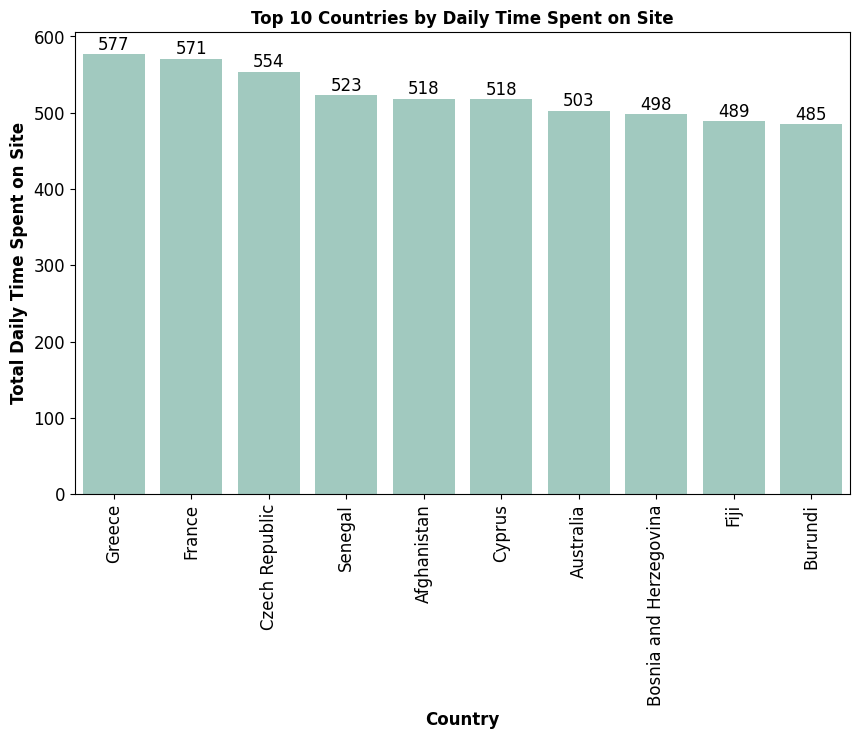

In [87]:
# calling a defined function 'bar_chart' for plotting  top 10 countries by 'Daily Time Spent on Site'
bar_chart(advertisement_data, 'Daily Time Spent on Site', 'Country', top_n=10)

* By looking at above bar plot it can be said that Greece stands out as the top country with the highest total daily time spent on the site with 577 minutes, followed closely by France 571 minutes and Czech Republic 554 minutes. This indicates that users from Greece are the most engaged spending more time on the site compared to other countries in the top 10.

* Total time spent across the top 10 countries shows a relatively small range (from 485 to 577 minutes). This suggests that users from these countries have similar engagement levels on the site.

In [88]:
def lineplot(data, x_column, y_column, color='#295F98'):
    """
    This function plots a line plot Hour_of_Day and Area Income column

    args:
        data: dataset containing required 2 columns
        x_column: first numerical column
        y_column: second numerical column
        color: color for the line plot
    """
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x_column, y=y_column, color=color)
    plt.title('Area Income by Hour of Day', fontsize=14, fontweight='bold')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.grid(True)
    plt.xlabel(x_column, fontsize=12, fontweight='bold')
    plt.ylabel(y_column, fontsize=12, fontweight='bold')
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    plt.show()

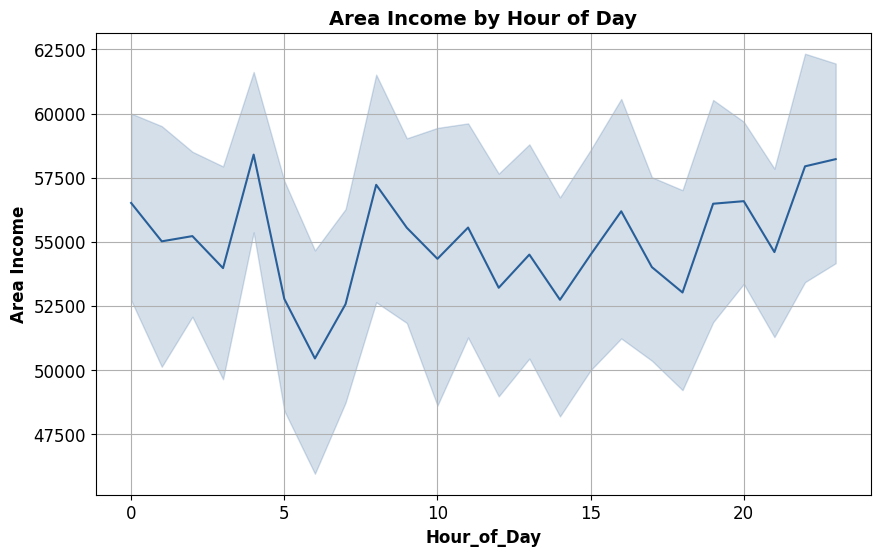

In [89]:
# calling a function 'lineplot' for plotting 'Area Income' against 'Hour_of_Day'
lineplot(advertisement_data, 'Hour_of_Day', 'Area Income')

* Area income fluctuates throughout the day with higher spikes observed around 9:00 AM and 23:00 PM. it suggests that income might be influenced by certain activities or events that peak during these hours.

* there is relatively lower area income during the early morning hours (from midnight to 6 AM) and late night (from 23:00 onwards). This might indicate that income generation or activity levels drop during these hours which could reflect lower site usage.

In [90]:
def custom_boxplot(data, num_col, cat_col):
    """
    It plots box plots for numerical features against categorical features

    args:
        data: dataset containing the column
        num_col: numerical columns to plot.
        cat_col: categorical column for grouping
    """
    color_1 = '#9AD0C2'
    color_2 = '#295F98'
    unique_values = data[cat_col].unique()
    palette = {unique_values[0]: color_1, unique_values[1]: color_2}

    for column in num_col:
        plt.figure(figsize=(10, 6))

        # Creating boxplot
        sns.boxplot(data=data, x=cat_col, y=column, hue=cat_col, palette=palette)

        # Adding titles and labels
        plt.title(f'Box Plot of {column} by {cat_col}', fontsize=14, fontweight='bold')
        plt.xlabel(cat_col, fontsize=12, fontweight='bold')
        plt.ylabel(column, fontsize=12, fontweight='bold')
        plt.xticks(fontsize=12, color='black')
        plt.yticks(fontsize=12, color='black')
        plt.legend(fontsize=12)
        plt.show()

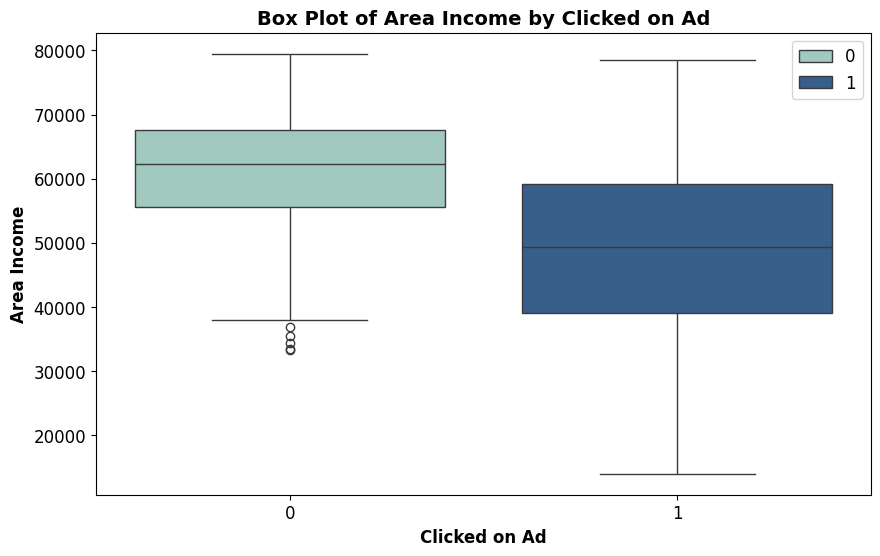

In [91]:
# calling a custom_boxplot function to plot a boxplot
num_col = ['Area Income']
custom_boxplot(advertisement_data, num_col, 'Clicked on Ad')

* This box plots shows that users who clicked on the ad have a higher median area income compared to those who did not click . Distribution for the "clicked" group is more concentrated towards higher area income values.

* There are several outliers (lower-income data points) in the group that did not click on the ad. This suggests that while the median income for non-clickers is lower, there is a subset of users with lower income which could influence the overall analysis.

# Scaling

In [92]:
# scaling the column values from the numerical columns using StandardScaler technique
col_to_standardize = ['Daily Time Spent on Site', 'Age']

# Initializing standardscalar and applying it on columns
scaler = StandardScaler()
advertisement_data[col_to_standardize] = scaler.fit_transform(advertisement_data[col_to_standardize])

In [93]:
advertisement_data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Hour_of_Day
0,0.249267,-0.114905,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,0
1,0.961132,-0.570425,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,1
2,0.282083,-1.139826,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,20
3,0.577432,-0.798185,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,2
4,0.212664,-0.114905,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,3


In [94]:
# defining a function to plot a elnow for finding optimal K value
def plot_elbow(data, max_k=10):
    """
    This function is defined to plot the elbow plot for kmeans clustering

    Parameters:
    data : dataset for clustering
    max_k : maximum number of clusters to consider

    Returns:
    None: displays the elbow plot
    """
    wcss = []

    # Iterating through k values to find the optimal number of clusters
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plotting the elbow plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), wcss, marker='o', color='#295F98')
    plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
    plt.grid(True)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    plt.show()

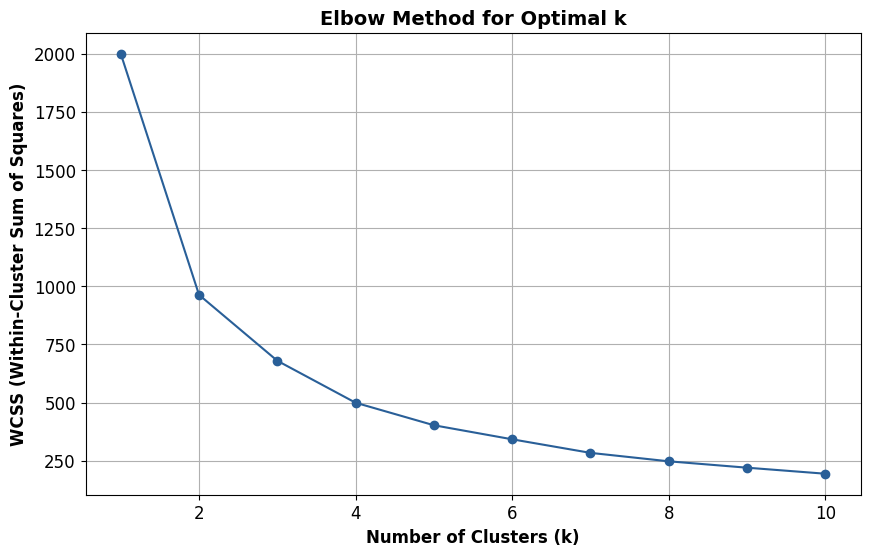

In [95]:
# calling the function
plot_elbow(advertisement_data[col_to_standardize])

In [96]:
# defining the function which applies kmeans clustering to dataset and add the cluster labels
def apply_kmeans(data, k):
    """
    This function  applies kmeans clustering and add the cluster labels

    Parameters:
    data : dataset for clustering
    k : number of clusters to use in kmeans

    Returns:
    dataframe: original dataset with an additional 'Cluster' column containing the cluster labels
    """
    # Initializing the kmeans algorithm
    ad_data = data.copy()
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)

    # Fitting model and adding labels in new formed column
    kmeans.fit(ad_data)
    ad_data['Cluster'] = kmeans.labels_

    return ad_data

In [97]:
# calling a function and passing the found optimal value of k
k = 2
df_with_clusters = apply_kmeans(advertisement_data[col_to_standardize], k)

In [98]:
df_with_clusters.head()

,Daily Time Spent on Site,Age,Cluster
0,0.249267,-0.114905,0
1,0.961132,-0.570425,0
2,0.282083,-1.139826,0
3,0.577432,-0.798185,0
4,0.212664,-0.114905,0


In [99]:
df_with_clusters['Cluster'].unique()

array([0, 1], dtype=int32)

# Kmeans

In [100]:
def optimal_kmeans_clustering(data, features, n_clusters=2, random_state=42):
    """
    This function applies kmeans clustering on the specified features

    Parameters:
        data : input columns
        features : List of column names
        n_clusters : Number of selected optimal clusters to form
        random_state: Random seed

    Returns:
        dataframe : df with extra added cluster column and kmeans object
    """
    # Select the features for clustering
    X = data[features]

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    data['Cluster'] = kmeans.fit_predict(X)

    return data, kmeans  # Return both dataframe and kmeans object

# Call the function and get the dataframe and kmeans model
df_with_clusters, kmeans_model = optimal_kmeans_clustering(
    data=advertisement_data,
    features=['Daily Time Spent on Site', 'Age'],
    n_clusters=2
)

In [101]:
# Backscaling scaled columns and cluster centers using the returned kmeans model
data_backscaled = scaler.inverse_transform(advertisement_data[col_to_standardize])
center_backscale = scaler.inverse_transform(kmeans_model.cluster_centers_)

In [102]:
data_backscaled

array([[68.95, 35.  ],
       [80.23, 31.  ],
       [69.47, 26.  ],
       ...,
       [51.63, 51.  ],
       [55.55, 19.  ],
       [45.01, 26.  ]])

In [103]:
center_backscale

array([[75.75690559, 31.08041958],
       [50.62441589, 42.59579439]])

In [104]:
def clusters_with_centers(data_backscaled, cluster_labels, centers, col_to_standardize):
    """
    This function plots the clusters along with their centers

    args:
        data_backscaled : backscaled data points
        cluster_labels : cluster labels assigned to each data point
        centers : cluster centers after backscaling.
        col_to_standardize : List of column names used for clustering
    """
    # Creating df for plotting
    df_backscaled = pd.DataFrame(data_backscaled, columns=col_to_standardize)
    df_backscaled['Cluster'] = cluster_labels

    # Scatter plot of the data points
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_backscaled, x=col_to_standardize[0], y=col_to_standardize[1], hue='Cluster',
                    palette="viridis", s=100, alpha=0.7, edgecolor='w', marker='o')

    # Plotting cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], s=200, c='orange', marker='X', label='Cluster Centers', edgecolor='k')

    # Adding titles and labels
    plt.title('Clusters and Their Centers', fontsize=14, fontweight='bold')
    plt.xlabel(col_to_standardize[0], fontsize=12, fontweight='bold')
    plt.ylabel(col_to_standardize[1], fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    plt.legend(fontsize=12)
    plt.show()

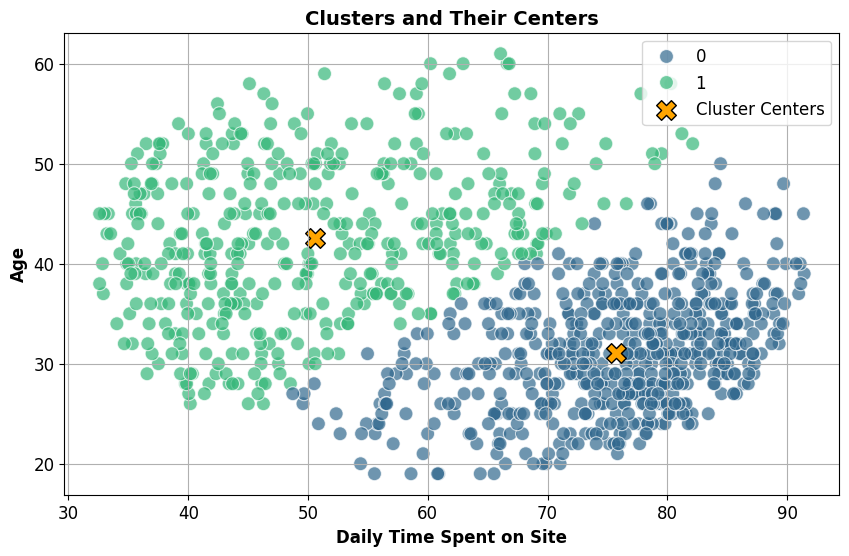

In [105]:
# calling a clusters_with_centers function tofor visualizing clusters and centers
clusters_with_centers(data_backscaled, df_with_clusters['Cluster'], center_backscale, col_to_standardize)

# Logistic Regression

In [106]:
# selecting features for fitting a model
X = df_with_clusters[['Age', 'Daily Time Spent on Site']]
y = df_with_clusters['Clicked on Ad']

# dividing dataset in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
def logistic_regree(X_train, y_train, random_state=42):
    """
    This function trains logistic regression model

    args:
    X_train : feature of the dataset matrix for training
    y_train : Target column for training the model
    random_state : random state

    Returns:
    model_lr : trained model
    """
    # Initializing and fitting random forest with training data
    log_reg = LogisticRegression(random_state=random_state)
    log_reg.fit(X_train, y_train)

    return log_reg

In [108]:
# calling a function - logistic_regree()
log_reg = logistic_regree(X_train, y_train)

In [109]:
# Predict on the test set
y_pred_lr = log_reg.predict(X_test)

# Evaluate the performance of the model and printing the results
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

print(f'->> Accuracy: {accuracy:.2f}')
print(f'->> F1 Score: {f1:.2f}')

->> Accuracy: 0.93
->> F1 Score: 0.93


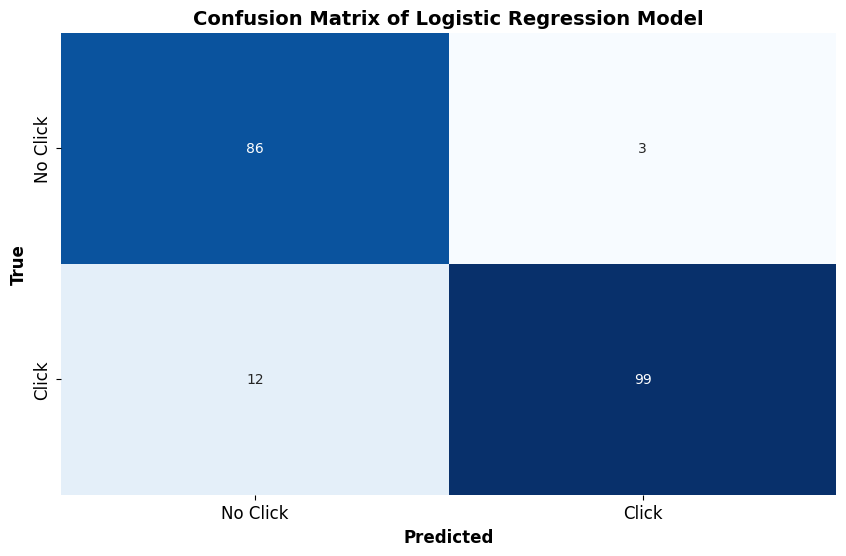

In [110]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'])
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix of Logistic Regression Model', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.show()

* Model correctly predicts "No Click" 86 times and "Click" 99 times. However it misclassifies 12 "Click" instances as "No Click" and 3 "No Click" instances as "Click".

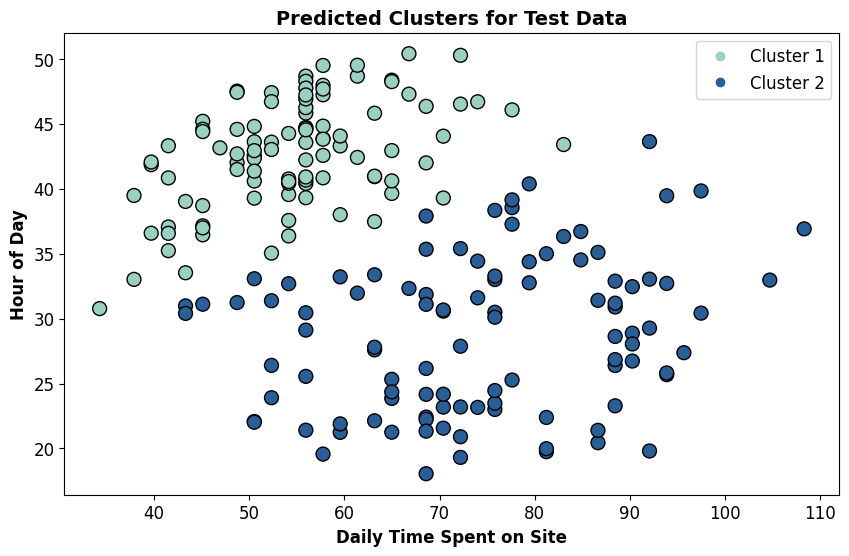

In [111]:
# plotting scatter plot for examining predicted clusters on the test dataset
# Adding  predicted clusters to the backscaled test data
X_test_backscaled = scaler.inverse_transform(X_test)
df_with_clusters.loc[X_test.index, 'Predicted_Cluster'] = y_pred_lr

# custom colors
color_1 = '#9AD0C2'
color_2 = '#295F98'

# Creating scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_test_backscaled[:, 0], X_test_backscaled[:, 1],
                      c=df_with_clusters.loc[X_test.index, 'Predicted_Cluster'],
                      cmap=plt.cm.colors.ListedColormap([color_1, color_2]),
                      edgecolors='k', s=100)

# Adding title and labels
plt.title('Predicted Clusters for Test Data', fontsize=14, fontweight='bold')
plt.xlabel('Daily Time Spent on Site', fontsize=12, fontweight='bold')
plt.ylabel('Hour of Day', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Cluster 1', 'Cluster 2'], fontsize=12)
plt.show()

The graph shows that the logistic regression model has classified the data points in clusters which indicates the good model performance in separating different user groups.

# Final Conclusion

Analysed the 'Advertisement - Click on Ad dataset' by using multiple statistical and exploratory data analysis techniques and also applied the kmeans clustering with help of elbow plot and seperated the data in clusters. At the end trained the logistic regression model which provided the 93% of both accuracy and f1 score and so performed well.

